# Dataset Loader for Vitabnet
This notebook demonstrates how to load and visualize the Vitabnet dataset using custom dataset loaders.

In [1]:
# Import required libraries
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# Add the src directory to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from datasets.table_dataset import PubTabNetDataset
from datasets.transforms.get_cells import GetCells
from datasets.transforms.load_tokens import LoadTokens
from mmocr.utils import register_all_modules
register_all_modules()

from mmocr.registry import TRANSFORMS
print('LoadTokens' in TRANSFORMS.module_dict)  # True nếu đã được đăng ký
print('GetCells' in TRANSFORMS.module_dict)  # True nếu đã được đăng ký

True
True


## Dataset Loading Cases
This notebook demonstrates three different dataset loading scenarios for the Vitabnet dataset:
- **Case 1 - Structure**: For table structure recognition (HTML generation only)
- **Case 2 - Content**: For cell content recognition (with cell extraction)
- **Case 3 - Both**: For combined structure and content tasks (with cell extraction)

Each case includes its own configuration setup, dataset loading, testing, and visualization.

## Case 1: Structure Dataset Loading
Load dataset for **Structure task** - Table structure recognition (HTML generation only).

### Configuration and Setup
This configuration focuses only on generating HTML table structure without cell content extraction.

In [2]:
# Case 1: Structure Dataset Configuration
print("=== CASE 1: STRUCTURE DATASET ===")
print("Task type: Structure (table structure recognition)")
print("Features: HTML table structure generation")
print("Pipeline: No additional transforms")
print("-" * 50)

# Dataset paths
json_path = VITABSET_TEST_JSON
img_path = VITABSET_TEST_IMAGE_ROOT

# Check if paths exist
if os.path.exists(img_path):
    print(f"✓ Image root exists: {img_path}")
    # Count image files
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_files.extend([f for f in os.listdir(img_path) if f.lower().endswith(ext)])
    print(f"  Found {len(image_files)} image files")
else:
    print(f"✗ Image root not found: {img_path}")

if os.path.exists(json_path):
    print(f"✓ Annotation file exists: {json_path}")
    file_size = os.path.getsize(json_path) / (1024 * 1024)  # MB
    print(f"  File size: {file_size:.2f} MB")
else:
    print(f"✗ Annotation file not found: {json_path}")

# Configuration for Structure task (table structure recognition)
structure_config = {
    'ann_file': json_path,
    'data_prefix': {'img_path': img_path},
    'task_type': 'structure',
    'split_filter': None,
    'max_structure_len': 500,
    'max_cell_len': 500,
    'ignore_empty_cells': True,
    'max_data': 100,  # Limit to 100 samples for testing
    'random_sample': False,
    'pipeline': []  # No additional transforms needed for structure
}

print('\n📋 Structure Configuration:')
for key, value in structure_config.items():
    if key == 'pipeline':
        print(f"  {key}: {len(value)} transforms")
    else:
        print(f"  {key}: {value}")

# Load Structure Dataset
print(f"\n🔄 Loading Structure dataset...")
structure_dataset = PubTabNetDataset(**structure_config)
print(f"✅ Structure dataset loaded successfully: {len(structure_dataset)} samples")
print("✅ Structure dataset ready for use!")

=== CASE 1: STRUCTURE DATASET ===
Task type: Structure (table structure recognition)
Features: HTML table structure generation
Pipeline: No additional transforms
--------------------------------------------------
✓ Image root exists: F:/data\vitabset\test
  Found 10209 image files
✓ Annotation file exists: F:/data\vitabset\test.bz2
  File size: 6.02 MB

📋 Structure Configuration:
  ann_file: F:/data\vitabset\test.bz2
  data_prefix: {'img_path': 'F:/data\\vitabset\\test'}
  task_type: structure
  split_filter: None
  max_structure_len: 500
  max_cell_len: 500
  ignore_empty_cells: True
  max_data: 100
  random_sample: False
  pipeline: 0 transforms

🔄 Loading Structure dataset...
✅ Structure dataset loaded successfully: 100 samples
✅ Structure dataset ready for use!


### Testing Structure Dataset Sample
Test the Structure dataset by examining a sample with structure-only instances.

In [3]:
import random

print("TESTING STRUCTURE DATASET SAMPLE:")
print("=" * 50)

# Test Structure dataset
structure_sample = structure_dataset[random.randint(0, len(structure_dataset) - 1)]
print(f"Sample keys: {list(structure_sample.keys())}")
print(f"Image path: {structure_sample.get('img_path', 'N/A')}")
print(f"Number of instances: {len(structure_sample.get('instances', []))}")

structure_instances = [inst for inst in structure_sample.get('instances', []) if inst.get('task_type') == 'structure']
print(f"Structure instances: {len(structure_instances)}")

if structure_instances:
    structure_tokens = structure_instances[0].get('tokens', [])
    structure_text = ' '.join(structure_tokens) if isinstance(structure_tokens, list) else str(structure_tokens)
    print(f"Structure tokens count: {len(structure_tokens) if isinstance(structure_tokens, list) else 'N/A'}")
    print(f"Structure text length: {len(structure_text)} characters")
    print(f"Structure text preview: {structure_text[:100]}...")
else:
    print("No structure instances found in this sample")

print("✅ Structure dataset sample test completed!")

TESTING STRUCTURE DATASET SAMPLE:
Sample keys: ['img_path', 'sample_idx', 'instances', 'img_info']
Image path: F:/data\vitabset\test\143676.png
Number of instances: 1
Structure instances: 1
Structure tokens count: 18
Structure text length: 104 characters
Structure text preview: <tbody> <tr> <td> </td> <td> </td> <td> </td> </tr> <tr> <td> </td> <td> </td> <td> </td> </tr> </tb...
✅ Structure dataset sample test completed!


### Structure Dataset Visualization
Visualize structure samples with HTML table representation.

In [4]:
from html import escape
def format_html(html_tokens, cells_tokens):
    ''' Formats HTML code from tokenized annotation of img
    '''
    html_code = html_tokens.copy()
    to_insert = [i for i, tag in enumerate(html_code) if tag in ('<td>', '>')]
    for i, cell_token in zip(to_insert[::-1], cells_tokens[::-1]):
        if cell_token:
            html_code.insert(i + 1, ''.join([escape(token) if len(token) == 1 else token for token in cell_token]))
    return '''<html>
                   <head>
                   <meta charset="UTF-8">
                   <style>
                   table, th, td {
                     border: 1px solid white;
                     font-size: 10px;
                   }
                   </style>
                   </head>
                   <body>
                   <table frame="hsides" rules="groups" width="100%%">
                     %s
                   </table>
                   </body>
                   </html>''' % ''.join(html_code)

format_html(
    ['<table>', '<tr>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '</tr>', '</table>'],
    [['Ce', 'll 1'], ['Cell', ' 2']]
)

'<html>\n                   <head>\n                   <meta charset="UTF-8">\n                   <style>\n                   table, th, td {\n                     border: 1px solid white;\n                     font-size: 10px;\n                   }\n                   </style>\n                   </head>\n                   <body>\n                   <table frame="hsides" rules="groups" width="100%">\n                     <table><tr><td>Cell 1</td></tr><tr><td>Cell 2</td></tr></table>\n                   </table>\n                   </body>\n                   </html>'

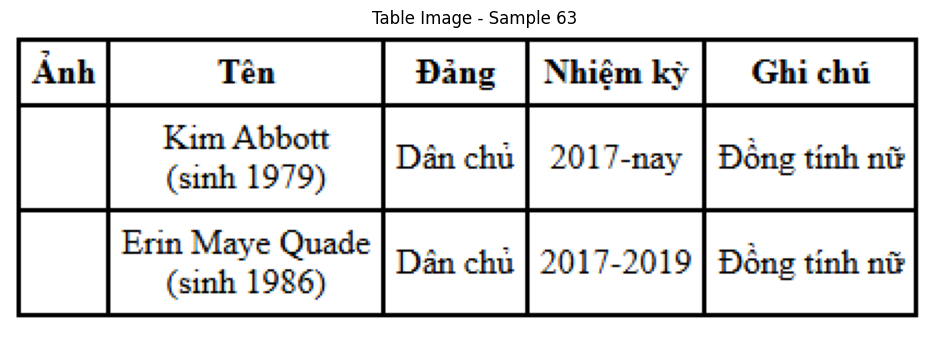

xxxx,xxxx,xxxx,xxxx,xxxx
xxxx,xxxx,xxxx,xxxx,xxxx
xxxx,xxxx,xxxx,xxxx,xxxx


--------------------------------------------------


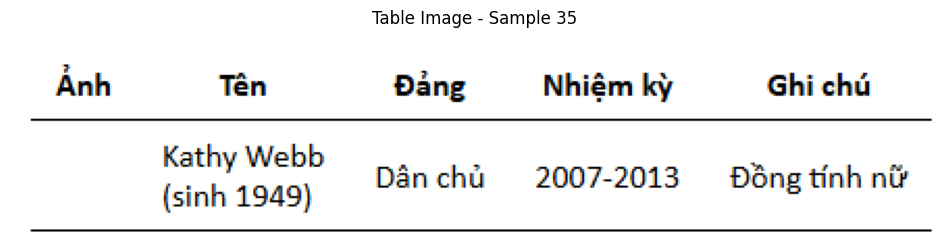

xxxx,xxxx,xxxx,xxxx,xxxx
xxxx,xxxx,xxxx,xxxx,xxxx


--------------------------------------------------


In [5]:
from IPython.display import HTML, display
import re

def visualize_structure_sample(dataset, idx, figsize=(12, 8)):
    """Visualize a structure sample with HTML table representation."""
    data_info = dataset.get_data_info(idx)
    
    # Load image
    img_path = data_info['img_path']
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
    
    image = Image.open(img_path)
    
    # Get structure text
    structure_instances = [inst for inst in data_info['instances'] if inst.get('task_type') == 'structure']
    
    if not structure_instances:
        print(f"No structure instances found for sample {idx}")
        return
    
    structure_tokens = structure_instances[0].get('tokens', [])
    
    # Display image
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(f'Table Image - Sample {idx}')
    plt.axis('off')
    plt.show()
    
    styled_html = format_html(structure_tokens, ['xxxx' for t in structure_tokens if t in ['<td>', '>']])
    display(HTML(styled_html))

# Demonstrate Structure Dataset Visualization
for i in [random.randint(0, len(structure_dataset) - 1) for _ in range(2)]:
    visualize_structure_sample(structure_dataset, i)
    print("-" * 50)


## Case 2: Content Dataset Loading
Load dataset for **Content task** - Cell content recognition with cell extraction.

### Configuration and Setup
This configuration focuses on extracting individual cell images and recognizing their text content.

In [6]:
# Case 2: Content Dataset Configuration
print("=== CASE 2: CONTENT DATASET ===")
print("Task type: Content (cell content recognition)")
print("Features: Cell image extraction + text recognition")
print("Pipeline: GetCell transform for cell extraction")
print("-" * 50)

# Dataset paths (same as structure)
json_path = VITABSET_TEST_JSON
img_path = VITABSET_TEST_IMAGE_ROOT

# Verify paths
print(f"📁 Using annotation file: {json_path}")
print(f"📁 Using image root: {img_path}")

# Configuration for Content task (cell content recognition with cell extraction)
content_config = {
    'ann_file': json_path,
    'data_prefix': {'img_path': img_path},
    'task_type': 'content',
    'split_filter': None,
    'max_structure_len': 500,
    'max_cell_len': 500,
    'ignore_empty_cells': True,
    'max_data': 100,  # Limit to 100 samples for testing
    'random_sample': False,
    'pipeline': [
        dict(type='LoadImageFromFile'),
        dict(type='LoadTokens', 
             with_structure=False,
             with_content=True,
             with_bbox=True,
             max_cell_len=500,
             flatten_tokens=False),
        dict(type='GetCells', 
             img_key='img',
             instances_key='instances',
             task_filter='content',
             min_cell_size=5)
    ]
}

print('\n📋 Content Configuration:')
for key, value in content_config.items():
    if key == 'pipeline':
        print(f"  {key}: {len(value)} transforms")
        for i, transform in enumerate(value):
            print(f"    Transform {i+1}: {transform['type']}")
    else:
        print(f"  {key}: {value}")

# Load Content Dataset
print(f"\n🔄 Loading Content dataset...")
content_dataset = PubTabNetDataset(**content_config)
print(f"✅ Content dataset loaded successfully: {len(content_dataset)} samples")
print("✅ Content dataset ready for use!")

=== CASE 2: CONTENT DATASET ===
Task type: Content (cell content recognition)
Features: Cell image extraction + text recognition
Pipeline: GetCell transform for cell extraction
--------------------------------------------------
📁 Using annotation file: F:/data\vitabset\test.bz2
📁 Using image root: F:/data\vitabset\test

📋 Content Configuration:
  ann_file: F:/data\vitabset\test.bz2
  data_prefix: {'img_path': 'F:/data\\vitabset\\test'}
  task_type: content
  split_filter: None
  max_structure_len: 500
  max_cell_len: 500
  ignore_empty_cells: True
  max_data: 100
  random_sample: False
  pipeline: 3 transforms
    Transform 1: LoadImageFromFile
    Transform 2: LoadTokens
    Transform 3: GetCells

🔄 Loading Content dataset...
✅ Content dataset loaded successfully: 100 samples
✅ Content dataset ready for use!


### Testing Content Dataset Sample
Test the Content dataset by examining a sample with extracted cell images and content instances.

In [7]:
print("TESTING CONTENT DATASET SAMPLE:")
print("=" * 50)

# Test Content dataset
content_sample = content_dataset[random.randint(0, len(content_dataset) - 1)]
print(f"Sample keys: {list(content_sample.keys())}")
print(f"Image path: {content_sample.get('img_path', 'N/A')}")
print(f"Number of instances: {len(content_sample.get('instances', []))}")

if 'cell_imgs' in content_sample:
    print(f"Number of extracted cells: {len(content_sample['cell_imgs'])}")
    print(f"Cell image shapes: {[img.shape for img in content_sample['cell_imgs'][:3]]}")

content_instances = [inst for inst in content_sample.get('instances', []) if inst.get('task_type') == 'content']
print(f"Content instances: {len(content_instances)}")

if 'cell_tokens' in content_sample:
    cell_tokens = content_sample['cell_tokens']
    print(f"Number of cell tokens: {len(cell_tokens)}")
    # Convert tokens to text for display
    cell_texts = [' '.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in cell_tokens]
    print(f"First few cell texts: {cell_texts[:3]}")

print("✅ Content dataset sample test completed!")

TESTING CONTENT DATASET SAMPLE:
Sample keys: ['img_path', 'sample_idx', 'instances', 'img_info', 'img', 'img_shape', 'ori_shape', 'gt_cell_tokens', 'gt_cell_ids', 'gt_cell_bboxes', 'gt_task_types', 'gt_tokens', 'cell_imgs']
Image path: F:/data\vitabset\test\144334.png
Number of instances: 9
Number of extracted cells: 9
Cell image shapes: [(29, 45, 3), (29, 43, 3), (29, 57, 3)]
Content instances: 9
✅ Content dataset sample test completed!


### Content Dataset Visualization
Visualize content samples with cell bounding boxes and extracted cells.


EXTRACTED CELLS DEMO:

Sample 95 - Showing 8 out of 13 extracted cells:


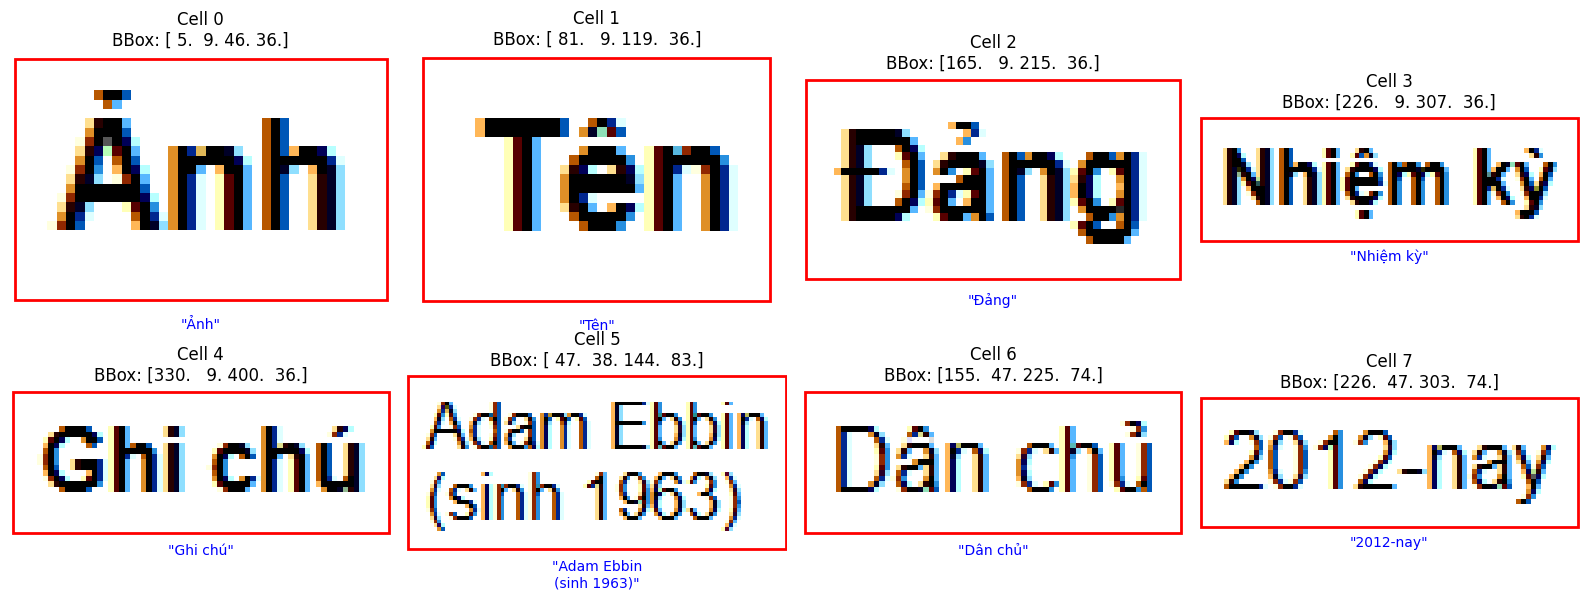


Sample 33 - Showing 8 out of 17 extracted cells:


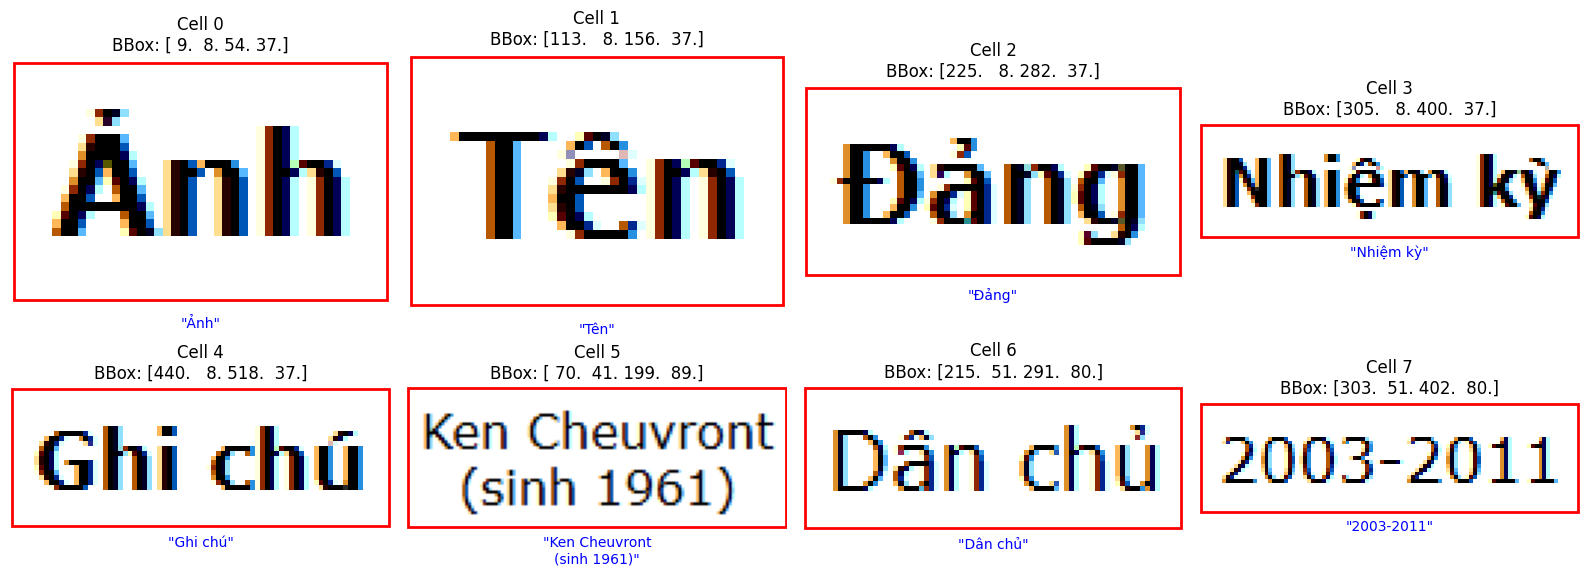


Sample 33 - Showing 8 out of 17 extracted cells:


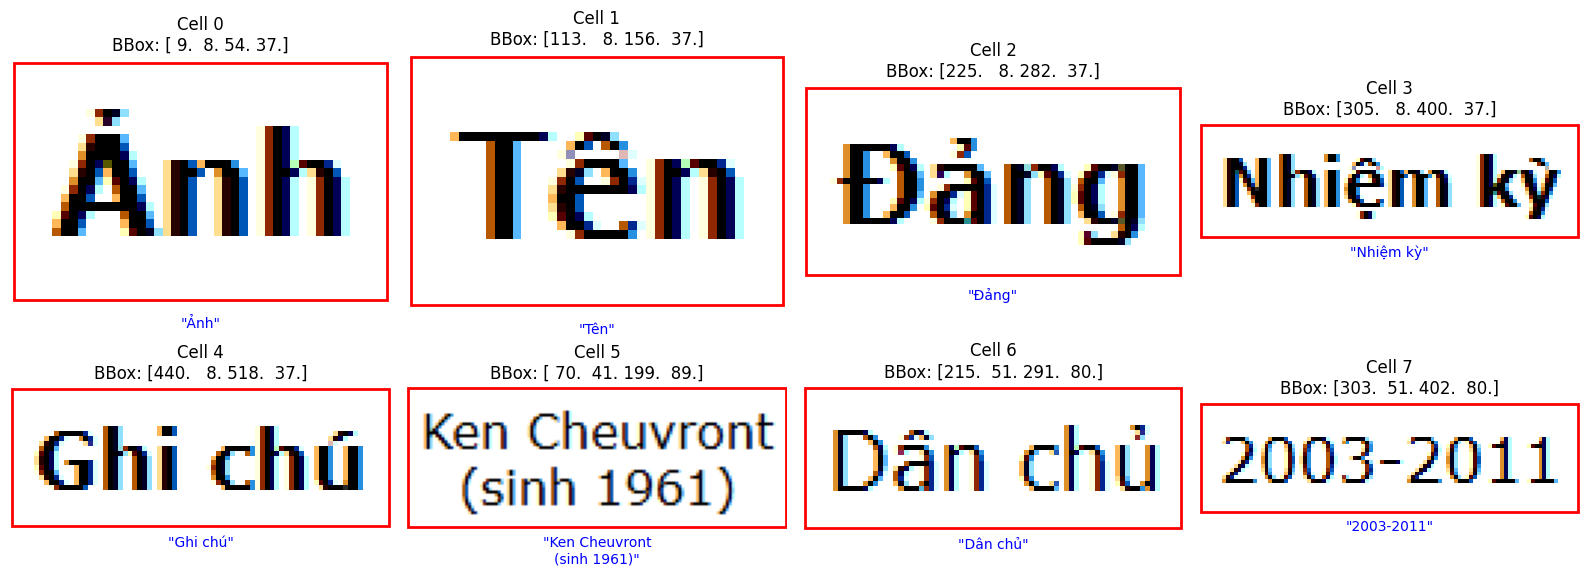

In [8]:
import matplotlib.patches as patches

def visualize_extracted_cells(dataset, idx, max_cells=8):
    """Visualize extracted cell samples from content dataset."""
    sample_data = dataset[idx]
    
    if 'cell_imgs' not in sample_data or not sample_data['cell_imgs']:
        print(f"No extracted cells available for sample {idx}")
        return
    
    cell_imgs = sample_data['cell_imgs']
    cell_tokens = sample_data.get('gt_cell_tokens', [])
    cell_bboxes = sample_data.get('gt_cell_bboxes', [])
    
    num_cells_to_show = min(max_cells, len(cell_imgs))
    
    print(f"\nSample {idx} - Showing {num_cells_to_show} out of {len(cell_imgs)} extracted cells:")
    
    # Create subplots for extracted cells
    cols = min(4, num_cells_to_show)
    rows = (num_cells_to_show + cols - 1) // cols
    
    if num_cells_to_show > 0:
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
        if num_cells_to_show == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if isinstance(axes, list) else [axes]
        else:
            axes = axes.flatten()
        
        for i in range(num_cells_to_show):
            cell_img = cell_imgs[i]
            tokens = cell_tokens[i] if i < len(cell_tokens) else []
            cell_text = ''.join(tokens) if isinstance(tokens, list) else str(tokens) if tokens else '<empty>'
            cell_bbox = cell_bboxes[i] if i < len(cell_bboxes) else []
            
            # Convert BGR to RGB for matplotlib if needed
            if len(cell_img.shape) == 3 and cell_img.shape[2] == 3:
                cell_img_rgb = cell_img[:, :, ::-1]
            else:
                cell_img_rgb = cell_img
            
            axes[i].imshow(cell_img_rgb)
            # Draw red border around the cell image
            rect = patches.Rectangle((0, 0), cell_img.shape[1]-1, cell_img.shape[0]-1, 
                                    linewidth=2, edgecolor='red', facecolor='none')
            axes[i].add_patch(rect)
            axes[i].set_title(f'Cell {i}\nBBox: {cell_bbox}')
            axes[i].axis('off')
            
            # Add text below the image
            if cell_text:
                display_text = cell_text.replace('<br>', '\n')
                if len(display_text) > 50:
                    display_text = display_text[:47] + '...'
                axes[i].text(0.5, -0.05, f'"{display_text}"', transform=axes[i].transAxes,  ha='center', va='top', fontsize=10, color='blue')
        
        # Hide unused subplots
        for i in range(num_cells_to_show, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Show extracted cells
print("\nEXTRACTED CELLS DEMO:")
for i in [random.randint(0, len(content_dataset) - 1) for _ in range(3)]:
    visualize_extracted_cells(content_dataset, i)

## Case 3: Both Dataset Loading  
Load dataset for **Both tasks** - Structure + Content recognition with cell extraction.

### Configuration and Setup
This configuration combines table structure recognition with cell content recognition.

In [9]:
# Case 3: Both Dataset Configuration
print("=== CASE 3: BOTH DATASET ===")
print("Task type: Both (structure + content recognition)")
print("Features: HTML structure generation + cell content recognition")
print("Pipeline: GetCell transform for cell extraction")
print("-" * 50)

# Dataset paths (same as previous cases)
json_path = VITABSET_TEST_JSON
img_path = VITABSET_TEST_IMAGE_ROOT

# Verify paths
print(f"📁 Using annotation file: {json_path}")
print(f"📁 Using image root: {img_path}")

# Configuration for Both tasks (structure + content with cell extraction)
both_config = {
    'ann_file': json_path,
    'data_prefix': {'img_path': img_path},
    'task_type': 'both',
    'split_filter': None,
    'max_structure_len': 500,
    'max_cell_len': 500,
    'ignore_empty_cells': True,
    'max_data': 100,  # Limit to 100 samples for testing
    'random_sample': False,
    'pipeline': [
        dict(type='LoadImageFromFile'),
        dict(type='LoadTokens', 
             with_structure=True,
             with_content=True,
             with_bbox=True,
             max_cell_len=500,
             flatten_tokens=False),
        dict(type='GetCells', 
             img_key='img',
             instances_key='instances',
             task_filter='both',
             min_cell_size=5)
    ]
}

print('\n📋 Both Configuration:')
for key, value in both_config.items():
    if key == 'pipeline':
        print(f"  {key}: {len(value)} transforms")
        for i, transform in enumerate(value):
            print(f"    Transform {i+1}: {transform['type']}")
    else:
        print(f"  {key}: {value}")

# Load Both Dataset
print(f"\n🔄 Loading Both dataset...")
both_dataset = PubTabNetDataset(**both_config)
print(f"✅ Both dataset loaded successfully: {len(both_dataset)} samples")
print("✅ Both dataset ready for use!")

=== CASE 3: BOTH DATASET ===
Task type: Both (structure + content recognition)
Features: HTML structure generation + cell content recognition
Pipeline: GetCell transform for cell extraction
--------------------------------------------------
📁 Using annotation file: F:/data\vitabset\test.bz2
📁 Using image root: F:/data\vitabset\test

📋 Both Configuration:
  ann_file: F:/data\vitabset\test.bz2
  data_prefix: {'img_path': 'F:/data\\vitabset\\test'}
  task_type: both
  split_filter: None
  max_structure_len: 500
  max_cell_len: 500
  ignore_empty_cells: True
  max_data: 100
  random_sample: False
  pipeline: 3 transforms
    Transform 1: LoadImageFromFile
    Transform 2: LoadTokens
    Transform 3: GetCells

🔄 Loading Both dataset...
✅ Both dataset loaded successfully: 100 samples
✅ Both dataset ready for use!


### Testing Both Dataset Sample
Test the Both dataset by examining a sample with both structure and content instances.

In [14]:
print("TESTING BOTH DATASET SAMPLE:")
print("=" * 50)

# Test Both dataset
both_sample = both_dataset[random.randint(0, len(both_dataset) - 1)]
print(f"Sample keys: {list(both_sample.keys())}")
print(f"Image path: {both_sample.get('img_path', 'N/A')}")
print(f"Number of instances: {len(both_sample.get('instances', []))}")

if 'cell_imgs' in both_sample:
    print(f"Number of extracted cells: {len(both_sample['cell_imgs'])}")

structure_instances = [inst for inst in both_sample.get('instances', []) if inst.get('task_type') == 'structure']
content_instances = [inst for inst in both_sample.get('instances', []) if inst.get('task_type') == 'content']
print(f"Structure instances: {len(structure_instances)}")
print(f"Content instances: {len(content_instances)}")

if structure_instances:
    structure_tokens = structure_instances[0].get('tokens', [])
    print(f"Structure tokens len: {len(structure_tokens) if isinstance(structure_tokens, list) else 'N/A'}")
    print(f"Structure tokens preview: {structure_tokens}")

if 'gt_cell_tokens' in both_sample:
    cell_tokens = [c.get('tokens',[]) for c in content_instances]
    print(f"Number of cell tokens: {len(cell_tokens)}")
    # Convert tokens to text for display
    cell_texts = [''.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in cell_tokens]
    print(f"First few cell texts: {cell_texts}")

print("✅ Both dataset sample test completed!")

TESTING BOTH DATASET SAMPLE:
Sample keys: ['img_path', 'sample_idx', 'instances', 'img_info', 'img', 'img_shape', 'ori_shape', 'gt_structure_tokens', 'gt_cell_tokens', 'gt_cell_ids', 'gt_cell_bboxes', 'gt_task_types', 'gt_tokens', 'cell_imgs']
Image path: F:/data\vitabset\test\144308.png
Number of instances: 14
Number of extracted cells: 13
Structure instances: 1
Content instances: 13
Structure tokens len: 40
Structure tokens preview: ['<thead>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</tbody>']
Number of cell tokens: 13
First few cell texts: ['Ảnh', 'Tên', 'Đảng', 'Nhiệm kỳ', 'Ghi chú', 'Kim Abbott<br>(sinh 1979)', 'Dân chủ', '2017-nay', 'Đồng tính nữ', 'Erin Maye Quade<br>(sinh 1986)', 'Dân chủ', '

### Both Dataset Visualization
Visualize both samples with combined structure and content visualization.

BOTH DATASET VISUALIZATION DEMO:


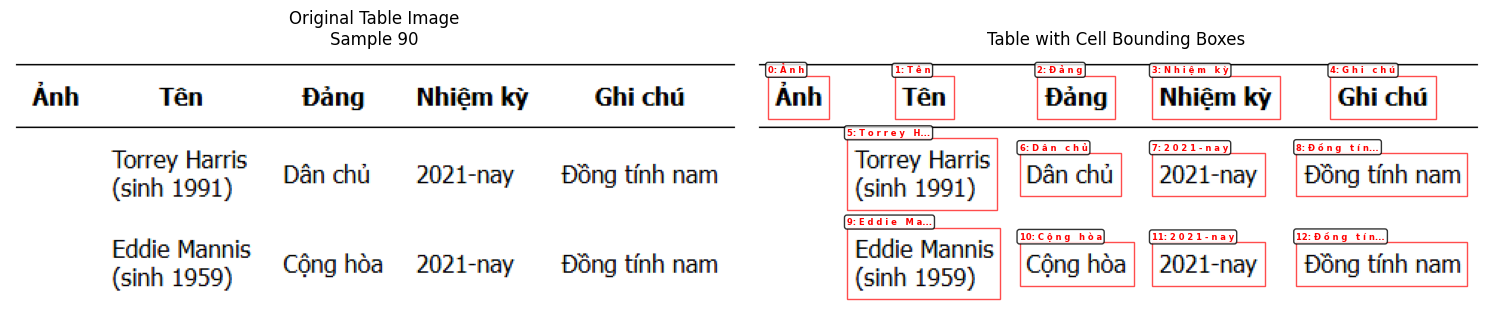

,,Ảnh,Tên,Đảng
Nhiệm kỳ,Ghi chú,Torrey Harris(sinh 1991),Dân chủ,2021-nay
Đồng tính nam,Eddie Mannis(sinh 1959),Cộng hòa,2021-nay,Đồng tính nam


------------------------------


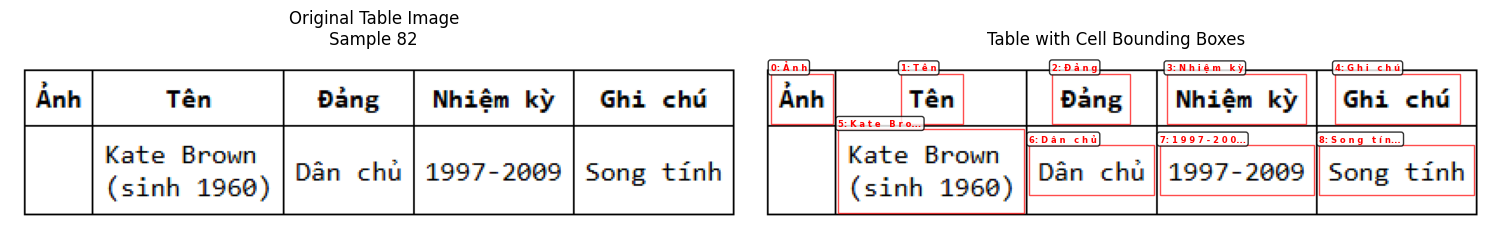

,Ảnh,Tên,Đảng,Nhiệm kỳ
Ghi chú,Kate Brown(sinh 1960),Dân chủ,1997-2009,Song tính


------------------------------

EXTRACTED CELLS FROM BOTH DATASET:

Sample 30 - Showing 8 out of 39 extracted cells:


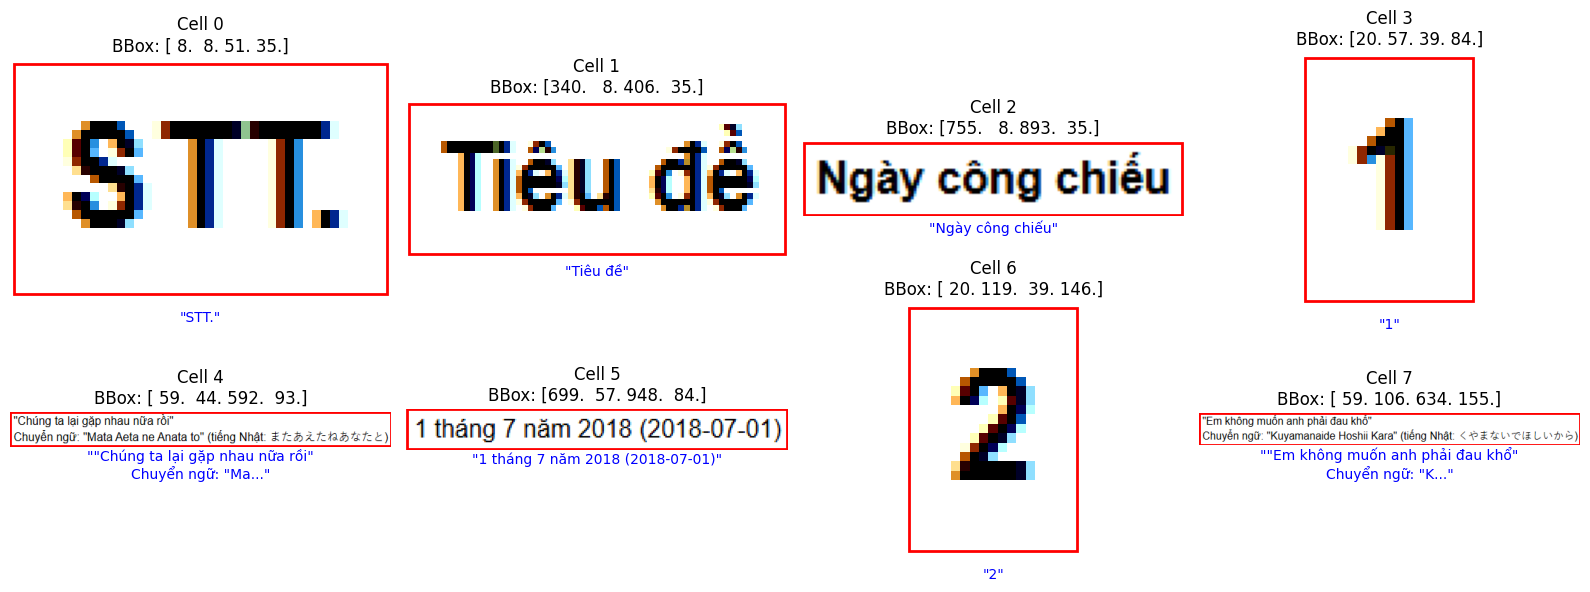

------------------------------

Sample 68 - Showing 8 out of 13 extracted cells:


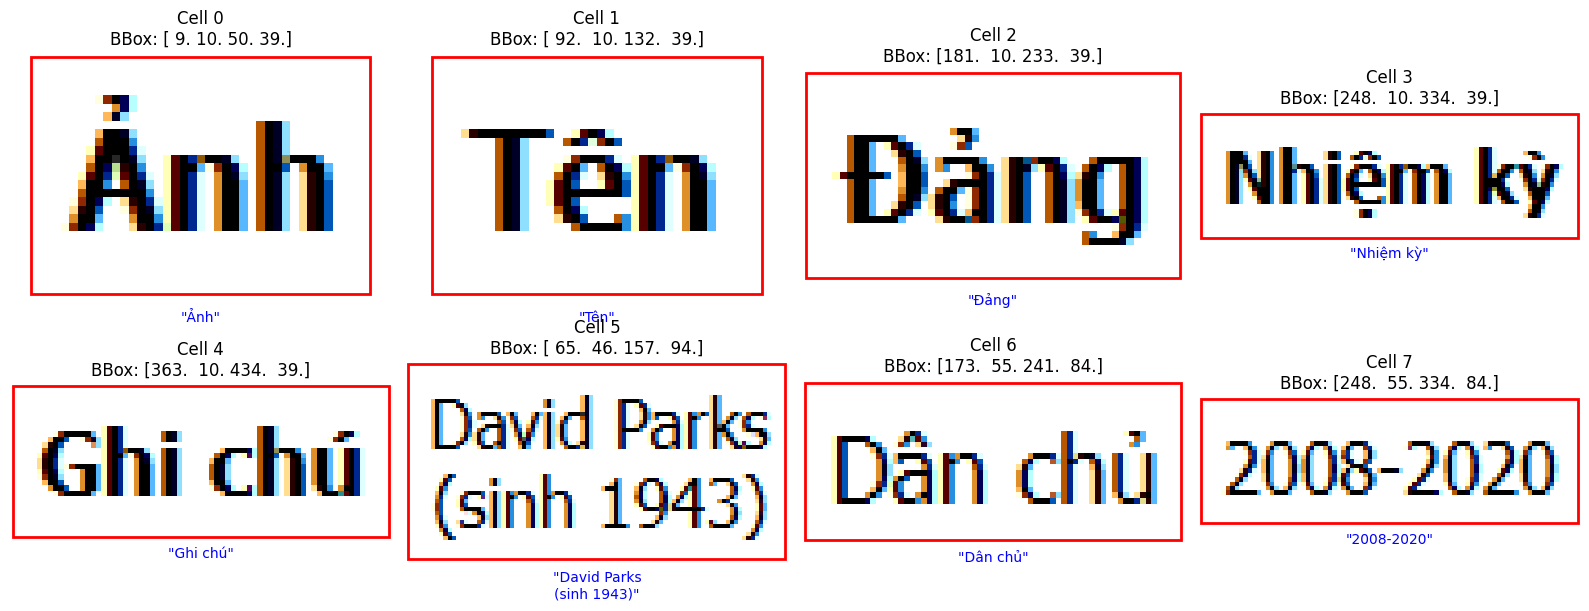

------------------------------


In [26]:
def visualize_both_sample(dataset, idx, figsize=(15, 10)):
    """Visualize a both sample with structure and content."""
    data_info = dataset.get_data_info(idx)
    
    # Load image
    img_path = data_info['img_path']
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
    
    image = Image.open(img_path)
    sample_data = dataset[idx]
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title(f'Original Table Image\nSample {idx}')
    axes[0].axis('off')
    
    # Plot image with cell bboxes
    axes[1].imshow(image)
    axes[1].set_title('Table with Cell Bounding Boxes')
    
    # Draw bounding boxes for content cells
    structure_instances = [inst for inst in sample_data.get('instances', []) if inst.get('task_type') == 'structure']
    content_instances = [inst for inst in sample_data['instances'] if inst.get('task_type') == 'content']

    for i, instance in enumerate(content_instances):
        if 'bbox' in instance:
            bbox = instance['bbox']
            x0, y0, x1, y1 = bbox
            width = x1 - x0
            height = y1 - y0
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x0, y0), width, height,
                linewidth=1, edgecolor='red', facecolor='none', alpha=0.7
            )
            axes[1].add_patch(rect)
            
            # Add cell text if available
            ins_tokens = instance.get('tokens', [])
            cell_text = ' '.join(ins_tokens) if isinstance(ins_tokens, list) else str(ins_tokens)
            if cell_text and len(cell_text) > 0:
                axes[1].text(
                    x0, y0-2, f'{i}: {cell_text[:15]}' + ('...' if len(cell_text) > 15 else ''), 
                    fontsize=6, color='red', weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
                )
    
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    structure_tokens = structure_instances[0].get('tokens', [])
    cell_tokens = [c.get('tokens',[]) for c in content_instances]

    styled_html = format_html(structure_tokens, cell_tokens)
    display(HTML(styled_html))

# Demonstrate Both Dataset Visualization
print("BOTH DATASET VISUALIZATION DEMO:")
print("=" * 50)

for i in [random.randint(0, len(both_dataset) - 1) for _ in range(2)]:
    visualize_both_sample(both_dataset, i)
    print("-" * 30)

# Show extracted cells from Both dataset
print("\nEXTRACTED CELLS FROM BOTH DATASET:")
print("=" * 40)
for i in [random.randint(0, len(both_dataset) - 1) for _ in range(2)]:
    visualize_extracted_cells(both_dataset, i)
    print("-" * 30)